In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
def id2name(team_id, team_df):
    name = team_df.loc[team_df['TEAM_ID']==team_id, 'NICKNAME'].values[0]
    return name


In [4]:
def prediction(mu_s, sigma_s, beta_inv):
    A = np.array([[1, -1]])
    mu_t = A @ mu_s
    sigma_t = beta_inv + A @ sigma_s @ A.T
    p = stats.norm.cdf(0, loc=mu_t, scale=np.sqrt(sigma_t))
    return -1 if p > 0.5 else 1

In [36]:
plt.rcParams['font.size'] = '16'

In [5]:
# Load the games data
NBA_games = pd.read_csv('games.csv', delimiter=',')
NBA_games = NBA_games[NBA_games['SEASON'] == 2022]
# NBA_games = NBA_games[['SEASON', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'HOME_TEAM_WINS']]
NBA_games.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-12-22,22200477,Final,1610612740,1610612759,2022,1610612740,126.0,0.484,0.926,...,25.0,46.0,1610612759,117.0,0.478,0.815,0.321,23.0,44.0,1
1,2022-12-22,22200478,Final,1610612762,1610612764,2022,1610612762,120.0,0.488,0.952,...,16.0,40.0,1610612764,112.0,0.561,0.765,0.333,20.0,37.0,1
2,2022-12-21,22200466,Final,1610612739,1610612749,2022,1610612739,114.0,0.482,0.786,...,22.0,37.0,1610612749,106.0,0.470,0.682,0.433,20.0,46.0,1
3,2022-12-21,22200467,Final,1610612755,1610612765,2022,1610612755,113.0,0.441,0.909,...,27.0,49.0,1610612765,93.0,0.392,0.735,0.261,15.0,46.0,1
4,2022-12-21,22200468,Final,1610612737,1610612741,2022,1610612737,108.0,0.429,1.000,...,22.0,47.0,1610612741,110.0,0.500,0.773,0.292,20.0,47.0,0


In [6]:
# Load team names
teams = pd.read_csv('teams.csv', delimiter=',')
# teams = teams[['TEAM_ID', 'NICKNAME']]
teams.head()

,LEAGUE_ID,TEAM_ID,MIN_YEAR,MAX_YEAR,ABBREVIATION,NICKNAME,YEARFOUNDED,CITY,ARENA,ARENACAPACITY,OWNER,GENERALMANAGER,HEADCOACH,DLEAGUEAFFILIATION
0,0,1610612737,1949,2019,ATL,Hawks,1949,Atlanta,State Farm Arena,18729.0,Tony Ressler,Travis Schlenk,Lloyd Pierce,Erie Bayhawks
1,0,1610612738,1946,2019,BOS,Celtics,1946,Boston,TD Garden,18624.0,Wyc Grousbeck,Danny Ainge,Brad Stevens,Maine Red Claws
2,0,1610612740,2002,2019,NOP,Pelicans,2002,New Orleans,Smoothie King Center,NaN,Tom Benson,Trajan Langdon,Alvin Gentry,No Affiliate
3,0,1610612741,1966,2019,CHI,Bulls,1966,Chicago,United Center,21711.0,Jerry Reinsdorf,Gar Forman,Jim Boylen,Windy City Bulls
4,0,1610612742,1980,2019,DAL,Mavericks,1980,Dallas,American Airlines Center,19200.0,Mark Cuban,Donnie Nelson,Rick Carlisle,Texas Legends


In [7]:
merged_df = NBA_games.merge(teams, left_on='HOME_TEAM_ID', right_on='TEAM_ID', how='left')\
    .merge(teams, left_on='VISITOR_TEAM_ID', right_on='TEAM_ID', how='left')


In [8]:
merged_df['HOME_TEAM'] = merged_df['CITY_x'] + ' ' + merged_df['NICKNAME_x']
merged_df['VISITOR_TEAM'] = merged_df['CITY_y'] + ' ' + merged_df['NICKNAME_y']

NBA_games = merged_df[['GAME_DATE_EST', 'HOME_TEAM', 'VISITOR_TEAM', 'PTS_home', 'PTS_away', 'HOME_TEAM_WINS']]\
    .rename(columns={'HOME_TEAM_WINS': 'Home_Team_Win_boo'})


In [9]:
NBA_games.head()


,GAME_DATE_EST,HOME_TEAM,VISITOR_TEAM,PTS_home,PTS_away,Home_Team_Win_boo
0,2022-12-22,New Orleans Pelicans,San Antonio Spurs,126.0,117.0,1
1,2022-12-22,Utah Jazz,Washington Wizards,120.0,112.0,1
2,2022-12-21,Cleveland Cavaliers,Milwaukee Bucks,114.0,106.0,1
3,2022-12-21,Philadelphia 76ers,Detroit Pistons,113.0,93.0,1
4,2022-12-21,Atlanta Hawks,Chicago Bulls,108.0,110.0,0


In [10]:
def get_posterior(initial_point, num_samples, y, beta_inv, m_s, sigma_s):
    # Produce a posteroir from Gibbs sampling

    point = np.array(initial_point)
    samples = np.empty([num_samples+1, 2]) 
    samples[0] = point
    A = np.array([[1, -1]])
    
    for i in range(num_samples):
        s1_sample, s2_sample = samples[i]
        if y==1:
            t = stats.truncnorm.rvs(a=0, b=np.inf, loc=(s1_sample - s2_sample), scale=np.sqrt(beta_inv))  # p(t|s1, s2, y)
        elif y==-1:
            t = stats.truncnorm.rvs(a=-np.inf, b=0, loc=(s1_sample - s2_sample), scale=np.sqrt(beta_inv))
            
        S = np.linalg.inv(np.linalg.inv(sigma_s) + (beta_inv)**(-1) * (A.T @ A))
        m = S @ (np.linalg.inv(sigma_s) @ m_s + beta_inv**(-1) * A.T * t)

        point = np.random.multivariate_normal(m.ravel(), S)
        samples[i+1] = point

    return m[0][0], m[1][0], S[0,0], S[1,1], point

In [89]:
# Set initial values
beta_inv = 1/30
num_samples = 400
mu_0 = 100
sigma_0 = 50

# Iterate through the data set to find all different teams and their skills
unique_teams = pd.concat([NBA_games['HOME_TEAM'], NBA_games['VISITOR_TEAM']]).unique()
skills_df = pd.DataFrame({'team': unique_teams,
    'mu': [mu_0] * len(unique_teams),
    'sigma': [sigma_0] * len(unique_teams),
    's' : np.random.normal(mu_0, np.sqrt(sigma_0))
})
skills_history = {team: [(mu_0, sigma_0)] for team in list(unique_teams)}

for _, match_instance in tqdm(NBA_games.iterrows(), total=NBA_games.shape[0], desc="Processing Matches", leave=True, position=0, unit='match'):
    team1, team2, home_team_wins = match_instance['HOME_TEAM'], match_instance['VISITOR_TEAM'], match_instance['Home_Team_Win_boo']
    
    # Collect match information
    mu1 = skills_df.loc[skills_df['team'] == team1, 'mu'].values[0]
    sigma1 = skills_df.loc[skills_df['team'] == team1, 'sigma'].values[0]
    mu2 = skills_df.loc[skills_df['team'] == team2, 'mu'].values[0]
    sigma2 = skills_df.loc[skills_df['team'] == team2, 'sigma'].values[0]
    s1 = skills_df.loc[skills_df['team'] == team1, 's'].values[0]
    s2 = skills_df.loc[skills_df['team'] == team2, 's'].values[0]

    y = 1 if home_team_wins else -1

    mu1_new, mu2_new, sigma1_new, sigma2_new, point = get_posterior(initial_point = [s1, s2],
                                                            num_samples = num_samples,
                                                            y = y,
                                                            beta_inv = beta_inv,
                                                            m_s = np.array([[mu1], [mu2]]),
                                                            sigma_s = np.array([[sigma1, 0], [0, sigma2]]))
    
    # Store the new values
    skills_history[team1].append((mu1_new, sigma1_new))
    skills_history[team2].append((mu2_new, sigma2_new))

    # Replace old values with the new ones
    skills_df.loc[skills_df['team'] == team1, 'mu'] = mu1_new
    skills_df.loc[skills_df['team'] == team1, 'sigma'] = sigma1_new
    skills_df.loc[skills_df['team'] == team2, 'mu'] = mu2_new
    skills_df.loc[skills_df['team'] == team2, 'sigma'] = sigma2_new
    skills_df.loc[skills_df['team'] == team1, 's'] = point[0]
    skills_df.loc[skills_df['team'] == team2, 's'] = point[1]


Processing Matches: 100%|██████████| 542/542 [00:19<00:00, 28.23match/s]


/var/folders/ys/b3y605yj63v2_9hpsb79b4kc0000gn/T/ipykernel_6139/3805038785.py:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


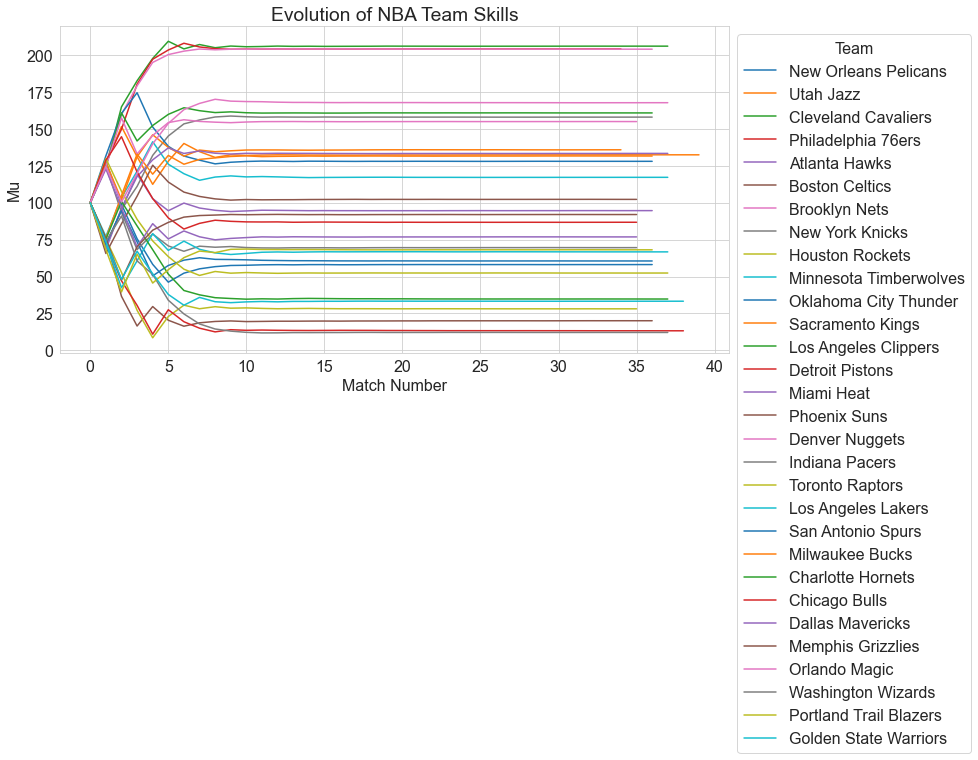

In [90]:
# Figure showing the evolution of skills for all the teams
plt.figure(figsize=(12, 6))
ax = plt.gca()

sns.set_style("whitegrid")

for team, mu_sigma_values in skills_history.items():
    mu_values = [mu for mu, sigma in mu_sigma_values]
    x_values = range(len(mu_values))
    sns.lineplot(x=x_values, y=mu_values, ax=ax, label=team)

plt.title("Evolution of NBA Team Skills")
plt.xlabel('Match Number')
plt.ylabel('Mu')
plt.legend(title='Team', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.savefig('NBA_team_skills.png', bbox_inches='tight')
plt.show()


In [92]:
# Prints a table of all team's 
sorted_skills_df = skills_df.sort_values(by='mu', ascending=False)

for i, (index, row) in enumerate(sorted_skills_df.iterrows()):
    team = row['team']
    mu = row['mu']
    sigma = row['sigma']
    print(f"{i+1:2d} -- Team: {team:<15s} | mean: {mu:>7.2f} | variance: {sigma:>7.4f}")

 1 -- Team: Cleveland Cavaliers | mean:  206.10 | variance:  0.0015
 2 -- Team: Philadelphia 76ers | mean:  204.21 | variance:  0.0015
 3 -- Team: Brooklyn Nets   | mean:  204.04 | variance:  0.0014
 4 -- Team: Orlando Magic   | mean:  167.78 | variance:  0.0015
 5 -- Team: Los Angeles Clippers | mean:  160.86 | variance:  0.0015
 6 -- Team: New York Knicks | mean:  158.02 | variance:  0.0015
 7 -- Team: Denver Nuggets  | mean:  154.99 | variance:  0.0015
 8 -- Team: Sacramento Kings | mean:  135.87 | variance:  0.0016
 9 -- Team: Miami Heat      | mean:  133.41 | variance:  0.0014
10 -- Team: Utah Jazz       | mean:  132.46 | variance:  0.0014
11 -- Team: Milwaukee Bucks | mean:  131.65 | variance:  0.0015
12 -- Team: Oklahoma City Thunder | mean:  128.06 | variance:  0.0015
13 -- Team: Minnesota Timberwolves | mean:  117.21 | variance:  0.0014
14 -- Team: Phoenix Suns    | mean:  102.27 | variance:  0.0016
15 -- Team: Atlanta Hawks   | mean:   94.65 | variance:  0.0015
16 -- Team: Me

In [94]:
pred_wins_team1 = []
true_wins_team1 = []
for _, match_instance in tqdm(NBA_games.iterrows(), total=NBA_games.shape[0], desc="Processing Matches", leave=True, position=0, unit='match'):
    team1, team2, home_team_wins = match_instance['HOME_TEAM'], match_instance[
        'VISITOR_TEAM'], match_instance['Home_Team_Win_boo']
    
    mu1 = skills_df.loc[skills_df['team'] == team1, 'mu'].values[0]
    sigma1 = skills_df.loc[skills_df['team'] == team1, 'sigma'].values[0]
    mu2 = skills_df.loc[skills_df['team'] == team2, 'mu'].values[0]
    sigma2 = skills_df.loc[skills_df['team'] == team2, 'sigma'].values[0]

    pred = prediction(mu_s=np.array([[mu1], [mu2]]),
                      sigma_s=np.array([[sigma1, 0], [0, sigma2]]),
                      beta_inv=beta_inv)

    pred_wins_team1.append(pred)
    true_wins_team1.append(1 if home_team_wins else -1)
r = sum(1 for pred, true in zip(pred_wins_team1, true_wins_team1)
        if pred == true) / len(true_wins_team1)
print(f"Prediction Rate = {round(r, 3)}")


Processing Matches: 100%|██████████| 542/542 [00:00<00:00, 2682.98match/s]

Prediction Rate = 0.581
